# ViT / DeiT Training

### 1. 데이터셋
- cifar10
- class 10 / train 6000 & test 1000

### 2. 모델
- ViT
- DeiT (CNN-ResNet18)

### 3. Loss Function
- LabelSmoothing

### 4. Optimizer
- Adam

### 5. Other Hyperparameters
- Batch size
- Epoch
- learning rate

### DeiT download

In [ ]:
!pip install timm

     |████████████████████████████████| 376 kB 5.3 MB/s 


### Step 1: Import requirements

In [ ]:
import os
import numpy as np
import sys
import time
# from tqdm import tqdm
from tqdm.auto import tqdm

from functools import partial
import timm
from timm.models.vision_transformer import VisionTransformer, _cfg

import torch
import torch.nn.init as init
import torch.backends.cudnn as cudnn
from torchvision import datasets, models
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchsummary import summary

### Step 2: Dataset Load

In [ ]:
transform_train = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10('data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10('data', train=False, transform=transform_test, download=True)

num_classes = len(train_dataset.classes)
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
train_dataset, test_dataset

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ), Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ))

In [ ]:
mixup_alpha = 1.0

def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, y, targets, smoothing=0.1):
        confidence = 1. - smoothing
        log_probs = F.log_softmax(y, dim=-1) # 예측 확률 계산
        true_probs = torch.zeros_like(log_probs)
        true_probs.fill_(smoothing / (y.shape[1] - 1))
        true_probs.scatter_(1, targets.data.unsqueeze(1), confidence) # 정답 인덱스의 정답 확률을 confidence로 변경
        return torch.mean(torch.sum(true_probs * -log_probs, dim=-1)) # negative log likelihood

### Model 

1. CNN - 성능 확인
2. ViT
3. DeiT

## 1. CNN 성능 확인

In [ ]:
# CNN 
cnn_model = models.resnet18(num_classes=num_classes)
cnn_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/checkpoint/resnet18.pth'))
cnn_model = cnn_model.cuda()
cnn_model.eval()

criterion = torch.nn.CrossEntropyLoss().cuda()

cnn_time = 0
with torch.no_grad():
  loss_val = 0
  num_correct = 0
  total = 0
  pbar = tqdm(total=int(len(test_dataset) / batch_size), disable=False)
  for i, data in enumerate(test_loader):
    cnn_start = time.time()
    inputs, labels = data[0].cuda(), data[1].cuda()
    total += labels.size(0)

    outputs = cnn_model(inputs)
    cost = criterion(outputs, labels)
    loss_val += cost.item()

    _, preds = torch.max(outputs, 1)
    num_correct += preds.eq(labels).sum().item()
    cnn_time += time.time() - cnn_start
    pbar.update()
  pbar.close()

print(f'Validation Loss: {loss_val / (len(test_dataset)/batch_size):.2f}. Accuracy: {num_correct / len(test_dataset) * 100:.1f}%')

cnn_result = num_correct / len(test_dataset) * 100
cnn_time = cnn_time / total
cnn_params = sum(p.numel() for p in cnn_model.parameters())

  0%|          | 0/156 [00:00<?, ?it/s]

Validation Loss: 0.63. Accuracy: 85.9%


## 2. ViT

In [ ]:
# ViT
# vit_model = timm.create_model('vit_base_patch16_224', pretrained=False)
vit_model = VisionTransformer(
        img_size=32, patch_size=8, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(torch.nn.LayerNorm, eps=1e-6))
vit_model.default_cfg = _cfg()
vit_model.head = torch.nn.Linear(vit_model.head.in_features, num_classes)
vit_model = vit_model.cuda()

summary(vit_model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 192, 4, 4]          37,056
          Identity-2              [-1, 16, 192]               0
        PatchEmbed-3              [-1, 16, 192]               0
           Dropout-4              [-1, 17, 192]               0
         LayerNorm-5              [-1, 17, 192]             384
            Linear-6              [-1, 17, 576]         111,168
           Dropout-7            [-1, 3, 17, 17]               0
            Linear-8              [-1, 17, 192]          37,056
           Dropout-9              [-1, 17, 192]               0
        Attention-10              [-1, 17, 192]               0
         Identity-11              [-1, 17, 192]               0
        LayerNorm-12              [-1, 17, 192]             384
           Linear-13              [-1, 17, 768]         148,224
             GELU-14              [-1, 

patch image

### Loss Function & Optimizer

- CrossEntrop
- Adam optimizer

In [ ]:
criterion = LabelSmoothingCrossEntropy().cuda()

optimizer = torch.optim.SGD(vit_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

### Training

In [ ]:
max_epoch = 200
vit_model.train()
total = 0
correct = 0

for epoch in range(max_epoch):
  total_loss = 0
  pbar = tqdm(total=int(len(train_dataset) / batch_size), disable=False)
  for i, data in enumerate(train_loader):
    inputs, labels = data[0].cuda(), data[1].cuda()
    inputs, targets_a, targets_b, lam = mixup_data(inputs, labels)
    optimizer.zero_grad()

    outputs = vit_model(inputs)
    loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

    loss.backward()
    optimizer.step()
    scheduler.step()

    total_loss += loss.item()
    
    _, pred = outputs.max(1)
    total += labels.size(0)
    current_correct = (lam * pred.eq(targets_a).sum().item() + (1-lam)*pred.eq(targets_b).sum().item())
    correct += current_correct

    pbar.set_description(
        f'[TRAIN] Epoch: {epoch+1}. Iteration: {i+1}/{int(len(train_dataset) / batch_size)+1}. LR: {optimizer.param_groups[0]["lr"]:.3f}.'
        f'Loss: {loss.item() / labels.size(0):.3f}. Accuracy: {current_correct / labels.size(0):.2f}'
    )
    pbar.update()
  pbar.close()

print(f'Train Done [Epoch] {max_epoch} / Loss: {total_loss / total} / Accuracy: {correct / total}')

  0%|          | 0/781 [00:00<?, ?it/s]

NameError: ignored

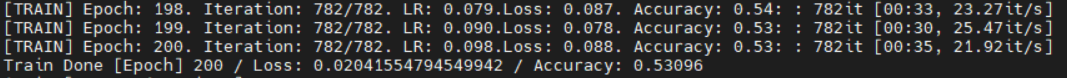

### Model save

In [ ]:
torch.save(vit_model.state_dict(), f'vit_cifar10.pth')

### Evaluation

In [ ]:
vit_model = VisionTransformer(
        img_size=32, patch_size=8, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(torch.nn.LayerNorm, eps=1e-6))
vit_model.default_cfg = _cfg()
vit_model.head = torch.nn.Linear(vit_model.head.in_features, num_classes)
vit_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/checkpoint/vit_cifar10.pth'))
vit_model = vit_model.cuda()

vit_model.eval()
criterion = torch.nn.CrossEntropyLoss().cuda()
 
vit_time = 0
with torch.no_grad():
  loss_val = 0
  num_correct = 0
  total = 0
  pbar = tqdm(total=int(len(test_dataset) / batch_size), disable=False)
  for i, data in enumerate(test_loader):
    vit_start = time.time()
    inputs, labels = data[0].cuda(), data[1].cuda()
    total += labels.size(0)

    outputs = vit_model(inputs)
    cost = criterion(outputs, labels)
    loss_val += cost.item()

    _, preds = torch.max(outputs, 1)
    num_correct += preds.eq(labels).sum().item()
    vit_time += time.time() - vit_start
    pbar.update()
  pbar.close()

print(f'Validation Loss: {loss_val / (len(test_dataset)/batch_size):.2f}. Accuracy: {num_correct / len(test_dataset) * 100:.1f}%')

vit_result = num_correct / len(test_dataset) * 100
vit_time = vit_time / total
vit_params = sum(p.numel() for p in vit_model.parameters())

  0%|          | 0/156 [00:00<?, ?it/s]

Validation Loss: 1.38. Accuracy: 50.4%


## Result annalysis

In [ ]:
import pandas as pd

result_dict = {'accuracy': [f'{cnn_result:.2f}%', f'{vit_result:.2f}%'], 'inference time':[f'{cnn_time:.6f}s', f'{vit_time:.6f}s'], 'num_params': [cnn_params, vit_params]}
# result_dict = {'cnn': [cnn_result, cnn_time], 'vit': [vit_result, vit_time]}

pd.DataFrame().from_dict(result_dict, orient='index', columns=['cnn', 'vit'])

,cnn,vit
accuracy,85.87%,50.39%
inference time,0.000261s,0.000322s
num_params,11181642,5381194


## 3. DeiT

In [ ]:
!git clone https://github.com/facebookresearch/deit.git

Cloning into 'deit'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 188 (delta 5), reused 1 (delta 0), pack-reused 176
Receiving objects: 100% (188/188), 1.43 MiB | 10.13 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [ ]:
cd deit

/content/deit


In [ ]:
ls

cait_models.py  LICENSE    README_cait.md    resmlp_models.py      utils.py
datasets.py     losses.py  README.md         run_with_submitit.py
engine.py       main.py    README_resmlp.md  samplers.py
hubconf.py      models.py  requirements.txt  tox.ini


In [ ]:
!python main.py --epochs 100 --model deit_small_distilled_patch16_224 --input-size 32 --teacher-path /content/drive/MyDrive/Colab_Notebooks/checkpoint/resnet18.pth --data-set CIFAR --data-path data/ --num_workers 1

Not using distributed mode
Namespace(aa='rand-m9-mstd0.5-inc1', batch_size=64, clip_grad=None, color_jitter=0.4, cooldown_epochs=10, cutmix=1.0, cutmix_minmax=None, data_path='data/', data_set='CIFAR', decay_epochs=30, decay_rate=0.1, device='cuda', dist_eval=False, dist_url='env://', distillation_alpha=0.5, distillation_tau=1.0, distillation_type='none', distributed=False, drop=0.0, drop_path=0.1, epochs=100, eval=False, finetune='', inat_category='name', input_size=32, lr=0.0005, lr_noise=None, lr_noise_pct=0.67, lr_noise_std=1.0, min_lr=1e-05, mixup=0.8, mixup_mode='batch', mixup_prob=1.0, mixup_switch_prob=0.5, model='deit_small_distilled_patch16_224', model_ema=True, model_ema_decay=0.99996, model_ema_force_cpu=False, momentum=0.9, num_workers=1, opt='adamw', opt_betas=None, opt_eps=1e-08, output_dir='', patience_epochs=10, pin_mem=True, recount=1, remode='pixel', repeated_aug=True, reprob=0.25, resplit=False, resume='', sched='cosine', seed=0, smoothing=0.1, start_epoch=0, teache

In [ ]:
!python main.py --eval --model deit_small_distilled_patch16_224 --resume /content/drive/MyDrive/Colab_Notebooks/checkpoint/checkpoint_deit.pth --data-set CIFAR --teacher-path /content/drive/MyDrive/Colab_Notebooks/checkpoint/resnet18.pth --input-size 32

Not using distributed mode
Namespace(aa='rand-m9-mstd0.5-inc1', batch_size=64, clip_grad=None, color_jitter=0.4, cooldown_epochs=10, cutmix=1.0, cutmix_minmax=None, data_path='/datasets01/imagenet_full_size/061417/', data_set='CIFAR', decay_epochs=30, decay_rate=0.1, device='cuda', dist_eval=False, dist_url='env://', distillation_alpha=0.5, distillation_tau=1.0, distillation_type='none', distributed=False, drop=0.0, drop_path=0.1, epochs=300, eval=True, finetune='', inat_category='name', input_size=32, lr=0.0005, lr_noise=None, lr_noise_pct=0.67, lr_noise_std=1.0, min_lr=1e-05, mixup=0.8, mixup_mode='batch', mixup_prob=1.0, mixup_switch_prob=0.5, model='deit_small_distilled_patch16_224', model_ema=True, model_ema_decay=0.99996, model_ema_force_cpu=False, momentum=0.9, num_workers=10, opt='adamw', opt_betas=None, opt_eps=1e-08, output_dir='', patience_epochs=10, pin_mem=True, recount=1, remode='pixel', repeated_aug=True, reprob=0.25, resplit=False, resume='/content/drive/MyDrive/Colab_N